### Clustering to soft-join related person data using LLM vector embeddings
David Sisk, 2026/02/04

Note: Generating vector embeddings, then using those in DBSCAN clustering does not seem to work very well for deduping/matching person records. 

In [63]:
#! pip install pandas
#! pip install scikit-learn
#! pip install networkx
#! pip install matplotlib
#! pip install hdbscan
#! pip install gensim

In [81]:
# Define the Ollama API endpoint
ollama_url = "http://ollamaserver_nuc1:11434/api/embed"
#model_name = "mxbai-embed-large"
model_name = "nomic-embed-text"  # 768 dimensions
#model_name = "all-minilm"


In [83]:
# Calculate and store vector embeddings using an Ollama LLM
import pandas as pd
import requests
import json

# Load the CSV file into a dataframe
df = pd.read_csv('sample-data-messy_200.csv')

# Function to generate embeddings for a row
def get_embedding(row):
    # Exclude the true_id column and concatenate other columns
    #text = " ".join(str(value) for key, value in row.items() if key != 'true_id')
    text = " ".join(str(value) for key, value in row.items() if key not in ['row_id', 'true_id'])
   
    payload = {
        "model": model_name,
        "input": text
    }
    
    response = requests.post(ollama_url, json=payload)
    embeddings = response.json()['embeddings'][0]
    return embeddings

# Apply the embedding function to each row
df['embedding'] = df.apply(get_embedding, axis=1)

print("df.shape:", df.shape)

embedding_dimension = len(df['embedding'].iloc[0])
print(f"The embedding dimension count is: {embedding_dimension}")

df.shape: (200, 7)
The embedding dimension count is: 768


In [78]:
# Calculate vector embeddings using a pretrained Doc2Vec model instead of an LLM
from gensim.models.doc2vec import Doc2Vec

# Load the CSV file into a dataframe
df = pd.read_csv('sample-data-messy_200.csv')

# Load the pretrained doc2vec model
doc2vec_model = Doc2Vec.load("doc2vec_wikipedia_dm.model")

# Function to generate embeddings for a row
def generate_doc2vec_embedding(row):
    # Exclude 'row_id' and 'true_id' columns and concatenate other columns
    text = " ".join(str(value) for key, value in row.items() if key not in ['row_id', 'true_id'])
    # Infer vector using the doc2vec model
    vector = doc2vec_model.infer_vector(text.split())
    return vector

# Apply the embedding function to each row
df['embedding'] = df.apply(generate_doc2vec_embedding, axis=1)

print("df.shape:", df.shape)

embedding_dimension = len(df['embedding'].iloc[0])
print(f"The embedding dimension count is: {embedding_dimension}")

df.shape: (200, 7)
The embedding dimension count is: 200


In [86]:
df.sample(3)

,row_id,name,email,address,phone,true_id,embedding,cluster
158,row-0243,"Hale, Victoria",vhale@mail.example.org,"7474 74 Sunset Rd, Springfield, IL 62774 Apt 14",(555) 010.0074,id-0074,"[0.005033657, 0.004583699, -0.17003734, -0.050998993, 0.023388758, -0.061100934, -0.010301428, 0.0187848, 0.00821636, 0.012432661, -0.053440474, 0.022980446, 0.016994962, 0.003443035, 0.0040692515, -0.054470908, 0.047917705, -0.086785026, -0.028228918, -0.016887492, -0.040353984, -0.009785095, -0.041905265, -0.047042713, 0.088751405, 0.03131755, 0.031180872, 0.03343404, -0.013716361, -0.02905302, 0.024680147, -0.046141334, -0.019392036, -0.039814387, -0.044842612, 0.039256055, 0.02149097, -0.004365592, 0.025656424, -0.0464658, 0.055727143, -0.06607547, -0.03074187, 0.0731016, -0.008254889, 0.011588075, -0.0027184917, 0.022949103, 0.09496865, -0.04234622, -0.002813251, -0.025799368, -0.028637717, -0.005462459, 0.049997233, 0.027098965, -0.009470398, -0.009182528, -0.0024085576, 0.043796077, 0.07862767, 0.051793486, 0.015102152, 0.0988374, 0.09866453, -0.007678977, -0.040006906, 0.04801836, 0.03980302, -0.040804382, 0.03589444, -0.046012767, -0.010161028, -0.015016393, -0.050773367, -0.0034278894, -0.015745182, -0.084656075, 0.024295922, 0.026018675, 0.030022314, 0.026143188, 0.02043746, -0.014658758, 0.068393916, -0.061156545, -0.02720971, -0.012494609, -0.04383872, 0.022618225, 0.008963104, 0.019964568, -0.014259138, -0.0074291145, -0.09562273, 0.030974288, 0.019225344, 0.026845198, -0.055634327, -0.034510847, ...]",24
170,row-0258,Benjamin Martin,NaN,NaN,(555) 010-0014,id-0014,"[-0.04930134, 0.011809447, -0.1320755, -0.031963293, 0.039095987, 0.02387598, 0.055608418, -0.028008755, -0.05904206, -0.030741408, -0.07923747, 0.06635649, -0.018618297, -0.0032538662, 0.041536953, -0.049007136, 0.0030452164, 0.009490576, -0.02294787, 0.03061766, -0.040680766, 0.021329315, -0.019222401, -0.047029022, 0.12307871, -0.029166482, 0.0559447, 0.030918026, 0.008539018, -0.035067286, 0.065280065, -0.04442956, -0.031393647, -0.015832528, -0.06328129, -0.03851866, 0.021239784, -0.028299766, 0.015926804, 0.018857973, 0.021117795, -0.019074643, 0.025296094, 0.03278989, -0.016509494, 0.02220477, 0.036149617, 0.033161763, 0.061646163, -0.041452233, -0.057757936, -0.017318752, -0.00042627245, 0.031141525, -0.021024635, 0.010184567, -0.019445568, -0.020034408, -0.036159664, 0.06424817, 0.11553481, 0.027992852, 0.02885458, 0.09844994, 0.032023948, 0.00536917, -0.011407195, 0.06577448, 0.03383302, -0.04927052, 0.017139476, 0.015152634, -0.031419117, 0.048521955, 0.014108106, -0.01719063, -0.002550896, -0.034202278, -0.033938147, 0.031217974, 0.01675427, -0.009780055, 0.06172742, -0.028123667, 0.059998233, -0.029809866, 0.011452126, -0.019248582, -0.058774255, 0.035810504, 0.034390613, 0.06380964, 0.019110562, -0.0029536802, -0.046768844, 0.005743267, 0.0031362425, 0.046643496, -0.052393038, -0.035806857, ...]",0
126,row-0204,"Hernandez, Jackson",jhernandez@mail.example.org,NaN,(555) 010.0027,id-0027,"[0.009059045, 0.027281212, -0.15409045, -0.047167532, 0.01958149, -0.005866469, 0.011321523, -0.040576532, -0.027512271, -0.023739342, -0.07711639, 0.076284416, 0.050262693, 0.01350468, 0.022556147, -0.0462646, 0.0075510307, -0.02519668, -0.023627087, 0.04683115, -0.02695828, -0.015727436, -0.056227747, -0.03146092, 0.10841688, 0.018518828, 0.025027556, 0.035642233, -0.048487224, -0.021394504, 0.008186333, -0.0073727504, -0.050402027, -0.031160345, -0.06731954, -0.016676242, 0.019998588, -0.015448647, 0.0069893543, -0.008269819, 0.019772138, -0.022555266, -0.006672521, 0.015443075, -0.017979046, 0.023346137, 0.041558646, 0.028999677, 0.07858208, -0.050631516, -0.019198742, -0.037855707, 0.023944726, 0.010597881, 0.023607098, 0.010193094, 0.005981712, -0.028608615, 0.0031949559, 0.028972952, 0.1262119, 0.058678582, 0.01226037, 0.08967512, 0.040155616, 0.019976005, -0.05125806, 0.066885926, 0.03413812, -0.05152701, 0.03109462, 0.013534321, -0.0431215, 0.028542893, -0.01994197

In [84]:
# Cluster using DBSCAN with cosine distance
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Convert df['embedding'] to a numpy array
embeddings_array = np.array(df['embedding'].tolist())

# Calculate cosine distance matrix from embeddings
cosine_dist_matrix = cosine_distances(embeddings_array)

# Apply DBSCAN clustering with precomputed cosine distances
dbscan = DBSCAN(eps=0.115, min_samples=3, metric='precomputed')
df['cluster'] = dbscan.fit_predict(cosine_dist_matrix)

df['cluster'].value_counts().sort_index()

cluster
-1    133
 0     44
 1      8
 2      3
 3      5
 4      7
Name: count, dtype: int64

In [85]:
# Tune HDBSCAN to target ~100 clusters (using precomputed cosine distances)
import hdbscan
import numpy as np

# Parameter sweep ranges (adjustable)
min_size_vals = [1,2,3,4,5,6,8]
min_samples_vals = [1,2,3,4]
methods = ['eom','leaf']
candidates = []

# Run sweep (using precomputed distance matrix)
for ms in min_size_vals:
    for mins in min_samples_vals:
        for method in methods:
            try:
                cl = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=ms, min_samples=mins, cluster_selection_method=method)
                labels = cl.fit_predict(cosine_dist_matrix)
                n_clusters = len(set(labels.tolist()) - {-1})
                candidates.append((ms, mins, method, n_clusters))
            except Exception as e:
                # skip invalid parameter combos
                candidates.append((ms, mins, method, None))

# Print sweep results
print('min_size	min_samples	method	#clusters')
for ms, mins, method, nc in candidates:
    print(f'{ms}	{mins}	{method}	{nc}')

# Select best candidate closest to target (100)
valid_candidates = [c for c in candidates if c[3] is not None]
if valid_candidates:
    target = 100
    best = min(valid_candidates, key=lambda x: abs(x[3]-target))
    chosen_min_size, chosen_min_samples, chosen_method, chosen_n = best
    print('Chosen (closest to target):', best)
    # Fit with chosen params and assign labels
    clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=chosen_min_size, min_samples=chosen_min_samples, cluster_selection_method=chosen_method)
    df['cluster'] = clusterer.fit_predict(cosine_dist_matrix)
    print('Resulting cluster counts:')
    print(df['cluster'].value_counts().sort_index())
else:
    print('No valid HDBSCAN configurations from sweep; try expanding ranges.')

min_size	min_samples	method	#clusters
1	1	eom	None
1	1	leaf	None
1	2	eom	None
1	2	leaf	None
1	3	eom	None
1	3	leaf	None
1	4	eom	None
1	4	leaf	None
2	1	eom	20
2	1	leaf	41
2	2	eom	7
2	2	leaf	18
2	3	eom	7
2	3	leaf	13
2	4	eom	7
2	4	leaf	12
3	1	eom	8
3	1	leaf	19
3	2	eom	7
3	2	leaf	13
3	3	eom	5
3	3	leaf	7
3	4	eom	5
3	4	leaf	6
4	1	eom	7
4	1	leaf	15
4	2	eom	7
4	2	leaf	10
4	3	eom	5
4	3	leaf	6
4	4	eom	5
4	4	leaf	5
5	1	eom	7
5	1	leaf	13
5	2	eom	5
5	2	leaf	6
5	3	eom	5
5	3	leaf	5
5	4	eom	5
5	4	leaf	5
6	1	eom	5
6	1	leaf	8
6	2	eom	4
6	2	leaf	5
6	3	eom	4
6	3	leaf	4
6	4	eom	4
6	4	leaf	4
8	1	eom	4
8	1	leaf	5
8	2	eom	4
8	2	leaf	5
8	3	eom	4
8	3	leaf	4
8	4	eom	4
8	4	leaf	4
Chosen (closest to target): (2, 1, 'leaf', 41)
Resulting cluster counts:
cluster
-1     83
 0      3
 1      2
 2      8
 3      2
 4      2
 5      2
 6      2
 7      3
 8      3
 9      3
 10     2
 11     2
 12     2
 13     3
 14     2
 15     2
 16     2
 17     2
 18     4
 19     5
 20     2
 21     2
 22     2
 23     2
 24     2

In [25]:
# Calculate row-level clustering score
def calculate_row_score(row):
    true_id = row['true_id']
    cluster = row['cluster']
    
    # Get all rows with the same true_id
    same_true_id = df[df['true_id'] == true_id]
    
    # Get clusters of other rows with the same true_id
    other_clusters = same_true_id[same_true_id.index != row.name]['cluster'].tolist()
    
    # Count how many other rows share the same cluster
    matching_clusters = sum(1 for c in other_clusters if c == cluster)
    
    # Score based on matches
    if matching_clusters == 2:
        return 1.0
    elif matching_clusters == 1:
        return 0.5
    else:
        return 0.0

# Apply the scoring function to each row
df['score'] = df.apply(calculate_row_score, axis=1)

df['score'].value_counts()

In [11]:
df.sample(3)

,row_id,name,email,address,phone,true_id,embedding,cluster,score
100,row-0170,Jeremiah Cook,NaN,NaN,(555) 010-0054,id-0054,"[-0.05163319, 0.009211943, -0.15316613, -0.04110646, 0.04809752, -0.0055467156, 0.058125257, -0.035443407, -0.06590851, -0.021127507, -0.060638607, 0.04526283, 0.023101568, 0.010623596, 0.043972887, -0.05456723, 0.011242183, 0.00034702572, -0.020230478, 0.025326462, -0.0438503, 0.04007414, -0.06130135, -0.047296327, 0.13217534, 0.0015336401, 0.05376249, 0.0050177146, 0.022605129, -0.00081234646, 0.06800465, -0.02260342, -0.029878518, -0.039211296, -0.059785698, -0.018759718, 0.014587966, -0.00867903, 0.018548092, 0.04689159, 0.029169317, -0.037990022, 0.035634518, -0.007468149, -0.01755466, 0.008036407, 0.02458215, 0.03434872, 0.06955394, 0.0029130694, -0.042012874, -0.020422034, 0.010554122, 0.009661027, -0.045705542, 0.035068344, -0.03985682, -0.0058244085, -0.021649774, 0.08021847, 0.08454043, 0.014968052, 0.023126947, 0.071222164, 0.02466259, 0.022941615, -0.0050945613, 0.06123649, 0.0074078455, -0.0594188, 0.025154721, 0.018942213, -0.008092868, 0.032451496, 0.0098061105, -0.0019740365, -0.017277978, -0.040434152, -0.02042947, 0.050483048, 0.018721996, -0.015315496, 0.04624869, -0.01629925, 0.045317613, -0.010440547, -0.008637961, -0.013381791, -0.041888196, 0.054263122, 0.0002040739, 0.058947533, 0.019172233, 0.012299294, -0.047754835, -0.010506997, 0.014331264, 0.042916417, -0.08808076, -0.032229565, ...]",0,0.5
12,row-0020,"Bailey, Cameron",cbailey@mail.example.org,"5858 58 Ridgecrest St, Springfield, IL 62758 Apt 18",(555) 010.0058,id-0058,"[-0.02878139, 0.033404984, -0.16520368, -0.06851706, 0.059205435, -0.06010004, 0.0447737, -0.009416572, 0.013969611, 0.0035856175, -0.052733, 0.023728859, 0.047595456, -0.017255949, 0.01955027, -0.041254804, 0.041707996, -0.06464336, 0.0052729133, 0.03328901, 0.0048699253, 0.05047665, -0.06741811, -0.038035456, 0.09730936, 0.04032007, 0.010756642, -0.004608715, -0.04631159, 0.013244479, -0.005420809, 0.0032297152, -0.06284979, -0.07409241, -0.058825456, -0.009276168, 0.020632403, -0.01648294, 0.020906707, 0.0036808713, 0.06837243, -0.020108521, 0.0041813236, 0.01562858, -0.0065266867, -0.0145107545, 0.049902085, 0.046074383, 0.087601334, -0.010238767, -0.0031465713, -0.009704398, 0.042676136, -0.016035315, 0.014088842, 0.033030692, -0.015856016, -0.0025646521, -0.0015550422, 0.05473628, 0.049066003, 0.040870953, -0.010488594, 0.041994907, 0.05158423, 0.025115179, -0.00035708508, 0.051558193, -0.023578726, -0.0498712, 0.037746802, -0.013422953, -0.044375516, 0.004582062, -0.017951932, 0.003393241, -0.030305652, -0.06540314, 0.00042605563, 0.06110249, 0.017850656, 0.030379798, 0.02251275, -0.03195379, 0.033257138, -0.021252608, -0.033972453, -0.020696916, -0.02184525, 0.04937141, -0.01939964, 0.014951788, 0.008846266, 0.009313378, -0.04100172, -0.019617194, 0.03281747, 0.021527901, -0.050168503, -0.030078076, ...]",0,0.5
171,row-0259,Gavin Brooks,NaN,"65 Hillcrest Rd., Springfield, IL 62765",(555) 010-0065,id-0065,"[-0.046571188, 0.020184835, -0.16473497, -0.027440252, 0.034914106, -0.014825, 0.06696226, -0.016788436, -0.06424467, -0.03158937, -0.046804678, 0.029790493, 0.025361843, -0.034493156, 0.031890795, -0.0628502, 0.010415323, -0.02260063, -0.0022913092, 0.04048843, -0.019480823, 0.04505207, -0.072722375, -0.048961375, 0.11494525, 0.022586973, 0.069202684, 0.010393728, 0.012061051, 0.011530759, 0.06023934, -0.016190179, -0.04036308, -0.05952417, -0.057211235, -0.017362049, 0.025675556, -0.013236899, 0.02660604, 0.045521475, 0.02727845, -0.013831318, 0.038950317, -0.010648853, -0.008548624, 0.007610267, 0.01786569, 0.038572393, 0.093625955, -0.010184679, -0.045845233, -0.0012367351, 0.016062176, 0.010791395, -0.029325636, 0.020475803, -0.054667573, -0.015932938, -0.01187116, 0.0639274, 0.050364964, 0.029751373, 0.014874874, 0.055446077, 0.022601051, 0.047786478, -0.011803735, 0.07187798, -0.022221727, -0.020538451, 0.033525597, -0.00376506, -2.2043081e-05,

In [ ]:
# Cluster using Graph
import networkx as nx
from difflib import SequenceMatcher
import string
import numpy as np

# Function to run graph-based clustering given thresholds
def graph_cluster(emb_dist_thresh=0.06, name_ratio_thresh=0.92, min_group_size=2):
    trans_table = str.maketrans("", "", string.punctuation)
    def norm_text(s):
        if pd.isna(s): return ""
        return str(s).lower().translate(trans_table).strip()
    def norm_phone(p):
        if pd.isna(p): return ""
        return "".join(ch for ch in str(p) if ch.isdigit())

    n = len(df)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # 1) Embedding-based edges (use precomputed cosine distance matrix)
    i_idx, j_idx = np.triu_indices(n, k=1)
    close_pairs = np.where(cosine_dist_matrix[i_idx, j_idx] < emb_dist_thresh)[0]
    for k in close_pairs:
        i, j = i_idx[k], j_idx[k]
        G.add_edge(i, j)

    # Helper to add edges between all indices that share a normalized key
    def connect_group(index_lists):
        for idxs in index_lists:
            if len(idxs) < 2: 
                continue
            for a in range(len(idxs)):
                for b in range(a+1, len(idxs)):
                    G.add_edge(idxs[a], idxs[b])

    # 2) Exact/normalized field matches: email, phone, address
    email_groups = df[~df['email'].isna()].groupby(df['email'].str.lower().str.strip()).apply(lambda g: g.index.tolist())
    connect_group(email_groups.tolist())

    df['_norm_phone'] = df['phone'].apply(norm_phone)
    phone_groups = df[df['_norm_phone'] != ""].groupby('_norm_phone').apply(lambda g: g.index.tolist())
    connect_group(phone_groups.tolist())

    df['_norm_address'] = df['address'].apply(norm_text)
    address_groups = df[df['_norm_address'] != ""].groupby('_norm_address').apply(lambda g: g.index.tolist())
    connect_group(address_groups.tolist())

    # 3) Fuzzy name matching (pairwise; acceptable for ~300 rows)
    names = df['name'].fillna("").tolist()
    for i in range(n):
        ni = names[i]
        if not ni: 
            continue
        for j in range(i+1, n):
            nj = names[j]
            if not nj:
                continue
            if SequenceMatcher(None, ni.lower(), nj.lower()).ratio() >= name_ratio_thresh:
                G.add_edge(i, j)

    # Compute connected components and assign cluster ids
    components = list(nx.connected_components(G))
    components.sort(key=lambda c: (min(c), -len(c)))
    cluster_map = {}
    cluster_id = 0
    for comp in components:
        if len(comp) < min_group_size:
            for idx in comp:
                cluster_map[idx] = -1
        else:
            for idx in comp:
                cluster_map[idx] = cluster_id
            cluster_id += 1

    labels = df.index.to_series().map(cluster_map).fillna(-1).astype(int)
    return labels

# Quick parameter sweep to find a setting that yields ~100 clusters (excluding noise)
emb_values = [0.03, 0.05, 0.06, 0.07, 0.08, 0.10]
name_values = [0.9, 0.92, 0.94]
candidates = []
for e in emb_values:
    for nr in name_values:
        labels = graph_cluster(emb_dist_thresh=e, name_ratio_thresh=nr, min_group_size=2)
        unique_clusters = set(labels.tolist()) - {-1}
        n_clusters = len(unique_clusters)
        candidates.append((e, nr, n_clusters))

# Show sweep results
print('emb_thresh	name_thresh	#clusters')
for e, nr, nc in candidates:
    print(f'{e}	{nr}	{nc}')

# Choose a candidate near ~100 clusters if available, otherwise pick a conservative split
# (Adjust these defaults if you want a different target)
chosen_e, chosen_nr = 0.06, 0.92
# Apply chosen thresholds and update dataframe
df['cluster'] = graph_cluster(emb_dist_thresh=chosen_e, name_ratio_thresh=chosen_nr, min_group_size=2)
# Cleanup temporary columns
df.drop(columns=['_norm_phone', '_norm_address'], inplace=True, errors='ignore')
# New cluster summary
cluster_counts = df['cluster'].value_counts().sort_index()
print('Chosen thresholds:', chosen_e, chosen_nr)
print(cluster_counts)

C:\Users\Dave Sisk\AppData\Local\Temp\ipykernel_32284\4193050107.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phone_groups = df[df['_norm_phone'] != ""].groupby('_norm_phone').apply(lambda g: g.index.tolist())
C:\Users\Dave Sisk\AppData\Local\Temp\ipykernel_32284\4193050107.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  address_groups = df[df['_norm_address'] != ""].groupby('_norm_address').apply(lambda

emb_thresh	name_thresh	#clusters
0.03	0.9	86
0.03	0.92	80
0.03	0.94	78
0.05	0.9	61
0.05	0.92	58
0.05	0.94	57
0.06	0.9	41
0.06	0.92	41
0.06	0.94	40
0.07	0.9	27
0.07	0.92	27
0.07	0.94	26
0.08	0.9	19
0.08	0.92	19
0.08	0.94	19
0.1	0.9	3
0.1	0.92	3
0.1	0.94	3


C:\Users\Dave Sisk\AppData\Local\Temp\ipykernel_32284\4193050107.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phone_groups = df[df['_norm_phone'] != ""].groupby('_norm_phone').apply(lambda g: g.index.tolist())
C:\Users\Dave Sisk\AppData\Local\Temp\ipykernel_32284\4193050107.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  address_groups = df[df['_norm_address'] != ""].groupby('_norm_address').apply(lambda

Chosen thresholds: 0.06 0.92
cluster
-1     25
 0      2
 1      2
 2      2
 3      2
 4      2
 5      2
 6      2
 7      2
 8      2
 9     85
 10     2
 11     2
 12     2
 13     2
 14     2
 15     2
 16    10
 17     2
 18     2
 19     2
 20     2
 21     2
 22     2
 23     2
 24     2
 25     2
 26     2
 27     2
 28     2
 29     2
 30     2
 31     2
 32     2
 33     2
 34     2
 35     2
 36     2
 37     4
 38     2
 39     2
 40     2
Name: count, dtype: int64


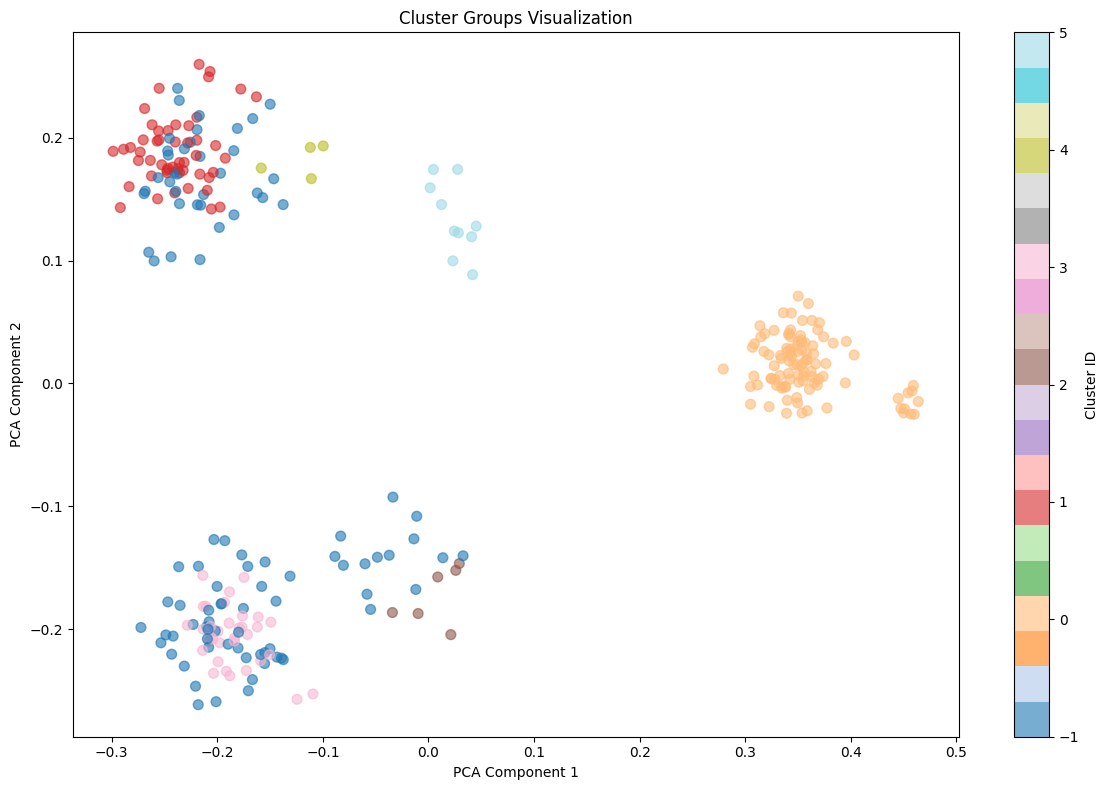

In [33]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='tab20', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Groups Visualization')
plt.tight_layout()
plt.show()